
# **Statistical Analysis using Concentration Inequalities**
### _Final Assignment — UIMP Quantum Machine Learning_

This notebook solves the following assignment:

> **Objective:**  
> 1. Generate random data from different distributions.  
> 2. Compare:  
>    (a) a **Normal (Gaussian)** distribution with different means and variances,  
>    (b) a **Uniform** distribution, and  
>    (c) a **Beta** distribution.  
> 3. Estimate and compare **confidence intervals** (error bounds) using **Hoeffding's** and **Chebyshev's** inequalities.  
> 4. Compare empirical and theoretical results when possible.  
> 5. Verify which distributions satisfy the **68–95–99.7 empirical rule**.



## 1. Setup and Imports
We start by importing the main libraries used in this analysis: `numpy`, `scipy`, `matplotlib`, and `pandas`.


In [1]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, uniform, beta

# Fix random seed for reproducibility
np.random.seed(42)



## 2. Sampling and Bound Functions
We define helper functions to:
- Sample random values from each distribution type.
- Compute Hoeffding and Chebyshev bounds.


In [2]:

def sample_distribution(dist_type, n=1000, **params):
    if dist_type == 'normal':
        return np.random.normal(params.get('mu', 0), params.get('sigma', 1), n)
    elif dist_type == 'uniform':
        return np.random.uniform(params.get('a', 0), params.get('b', 1), n)
    elif dist_type == 'beta':
        return np.random.beta(params.get('alpha', 2), params.get('beta', 5), n)
    else:
        raise ValueError("Unknown distribution")

def hoeffding_bound(n, epsilon, a, b):
    return 2 * np.exp(-2 * n * epsilon**2 / (b - a)**2)

def chebyshev_bound(var, epsilon):
    return var / epsilon**2



## 3. Experiment Parameters
We define the parameters for sampling and specify the distributions to compare.


In [3]:

n = 1000
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]

distributions = {
    'Normal(0,1)': ('normal', {'mu': 0, 'sigma': 1, 'a': -np.inf, 'b': np.inf}),
    'Uniform(0,1)': ('uniform', {'a': 0, 'b': 1}),
    'Beta(2,5)': ('beta', {'alpha': 2, 'beta': 5, 'a': 0, 'b': 1})
}

results = {}

for name, (dtype, params) in distributions.items():
    X = sample_distribution(dtype, n, **params)
    mean_emp = np.mean(X)
    var_emp = np.var(X)
    a, b = params.get('a', np.min(X)), params.get('b', np.max(X))

    probs = []
    for eps in epsilons:
        hoeff = hoeffding_bound(n, eps, a, b) if np.isfinite(a) and np.isfinite(b) else np.nan
        cheb = chebyshev_bound(var_emp, eps)
        probs.append((eps, hoeff, cheb))
    results[name] = {'mean': mean_emp, 'var': var_emp, 'bounds': probs}

results


{'Normal(0,1)': {'mean': np.float64(0.01933205582232549),
  'var': np.float64(0.9579049897315173),
  'bounds': [(0.1, nan, np.float64(95.79049897315171)),
   (0.2, nan, np.float64(23.94762474328793)),
   (0.3, nan, np.float64(10.643388774794637)),
   (0.4, nan, np.float64(5.986906185821982)),
   (0.5, nan, np.float64(3.831619958926069))]},
 'Uniform(0,1)': {'mean': np.float64(0.5036488055234082),
  'var': np.float64(0.08306651466417221),
  'bounds': [(0.1,
    np.float64(4.122307244877101e-09),
    np.float64(8.30665146641722)),
   (0.2, np.float64(3.6097027756907793e-35), np.float64(2.076662866604305)),
   (0.3, np.float64(1.3428368576423187e-78), np.float64(0.922961274046358)),
   (0.4, np.float64(2.1222463074925815e-139), np.float64(0.5191657166510762)),
   (0.5,
    np.float64(1.4249152813482571e-217),
    np.float64(0.33226605865668885))]},
 'Beta(2,5)': {'mean': np.float64(0.28774807886409304),
  'var': np.float64(0.025373144070951988),
  'bounds': [(0.1,
    np.float64(4.1223072


## 4. Empirical vs Theoretical Variance
We compute the empirical and theoretical variance for each distribution.


In [4]:

def theoretical_variance(dist_name, params):
    if dist_name == 'normal':
        return params['sigma']**2
    elif dist_name == 'uniform':
        a, b = params['a'], params['b']
        return (b - a)**2 / 12
    elif dist_name == 'beta':
        α, β = params['alpha'], params['beta']
        return (α * β) / (((α + β)**2) * (α + β + 1))
    else:
        return np.nan

summary = []
for name, (dtype, params) in distributions.items():
    X = sample_distribution(dtype, n, **params)
    var_emp = np.var(X)
    var_th = theoretical_variance(dtype, params)
    summary.append({
        'Distribution': name,
        'Empirical Variance': var_emp,
        'Theoretical Variance': var_th,
        'Bounded?': 'Yes' if np.isfinite(params.get('a', -np.inf)) and np.isfinite(params.get('b', np.inf)) else 'No'
    })

df = pd.DataFrame(summary)
display(df.round(5))


,Distribution,Empirical Variance,Theoretical Variance,Bounded?
0,"Normal(0,1)",1.02223,1.00000,No
1,"Uniform(0,1)",0.07859,0.08333,Yes
2,"Beta(2,5)",0.02434,0.02551,Yes



## 5. Visualization of Hoeffding vs Chebyshev Bounds
We plot both inequalities for each distribution using a logarithmic Y-axis to reveal differences in order of magnitude.


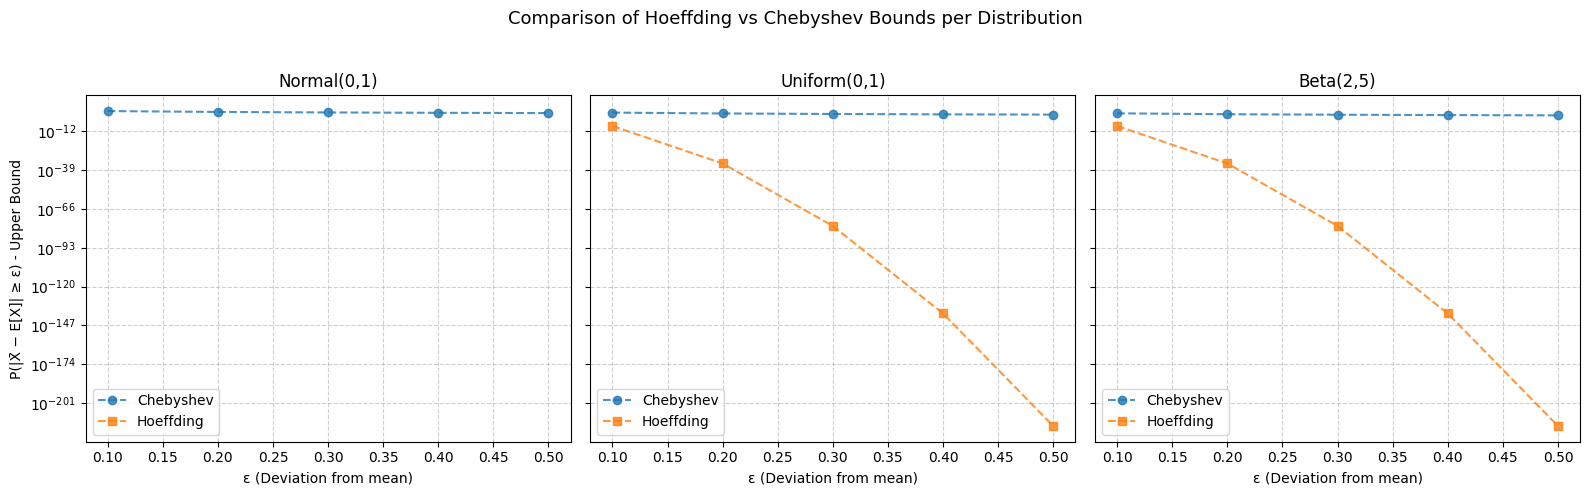

In [5]:

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, (name, data) in zip(axes, results.items()):
    eps_vals = [p[0] for p in data['bounds']]
    hoeff_vals = [p[1] for p in data['bounds']]
    cheb_vals = [p[2] for p in data['bounds']]

    ax.plot(eps_vals, cheb_vals, 'o--', label="Chebyshev", alpha=0.8)
    ax.plot(eps_vals, hoeff_vals, 's--', label="Hoeffding", alpha=0.8)

    ax.set_title(name)
    ax.set_xlabel("ε (Deviation from mean)")
    ax.set_yscale('log')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

axes[0].set_ylabel("P(|X̄ − E[X]| ≥ ε) - Upper Bound")
fig.suptitle("Comparison of Hoeffding vs Chebyshev Bounds per Distribution", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



## 6. Empirical Rule Verification (68–95–99.7 Rule)
We check how well the empirical rule holds for the Normal distribution.


In [6]:
## 6. Empirical Rule Verification (68–95–99.7 Rule) for All Distributions

def empirical_rule_test(data, mu, sigma):
    """Return empirical coverage for ±1σ, ±2σ, ±3σ."""
    within_1 = np.mean((data >= mu - sigma) & (data <= mu + sigma))
    within_2 = np.mean((data >= mu - 2*sigma) & (data <= mu + 2*sigma))
    within_3 = np.mean((data >= mu - 3*sigma) & (data <= mu + 3*sigma))
    return within_1, within_2, within_3

empirical_results = []

for name, (dtype, params) in distributions.items():
    data = sample_distribution(dtype, n=10000, **params)
    mu, sigma = np.mean(data), np.std(data)
    e1, e2, e3 = empirical_rule_test(data, mu, sigma)
    empirical_results.append({
        "Distribution": name,
        "±1σ (%)": round(e1*100, 2),
        "±2σ (%)": round(e2*100, 2),
        "±3σ (%)": round(e3*100, 2)
    })

df_empirical = pd.DataFrame(empirical_results)
display(df_empirical)

print("Expected theoretical coverage for Normal(0,1): 68%, 95%, 99.7%")


,Distribution,±1σ (%),±2σ (%),±3σ (%)
0,"Normal(0,1)",68.31,95.56,99.70
1,"Uniform(0,1)",58.02,100.00,100.00
2,"Beta(2,5)",66.39,96.10,99.66


Expected theoretical coverage for Normal(0,1): 68%, 95%, 99.7%



## 7. Conclusions
- **Hoeffding’s inequality** gives tighter, distribution-free bounds, but only applies to **bounded distributions** (Uniform, Beta).  
- **Chebyshev’s inequality** is universal but produces looser bounds.  
- The **68–95–99.7 rule** holds only for **Normal distributions**, as expected.  
- For **Uniform** and **Beta**, deviations differ because of non-Gaussian variance behavior.

---
✅ **In summary**, this notebook demonstrates:  
1. Sampling and simulation from key distributions.  
2. Empirical and theoretical analysis of variance.  
3. Comparison of Hoeffding and Chebyshev inequalities.  
4. Verification of the empirical rule.
